### Spread Analisys and Market Regime Overlay

- This notebook analyzes the mean reversion properties of crypto futures calendar spreads, focusing on regime detection and trade analytics.
- We load and preprocess spread data, computing rolling and volatility-adjusted features.
- A Gaussian Mixture Model (GMM) is applied to identify distinct market regimes based on spread variance, volume, and term structure changes.
- For each spread, we simulate mean reversion trades using z-score thresholds.
- Trade statistics are evaluated, including Sharpe ratio, edge per bar, and reversion time.
- Both the spread series and regime overlays are visualized for deeper insight.
- Summary statistics and aggregate plots provide a comprehensive view of spread behavior and regime-dependent performance across the BTC futures curve.

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/liquid_spread_series_flat.csv')

In [7]:
display(df.head())

spread  log_spread  vol_adj_spread  close_far  close_near  beta  \
0  8.591206   -0.013595             NaN    48006.6     47952.9   NaN   
1  8.564519   -0.013594             NaN    47952.8     47899.2   NaN   
2  1.640901   -0.013739             NaN    47963.2     47916.5   NaN   
3 -8.339303   -0.013947             NaN    47938.7     47902.0   NaN   
4 -8.245037   -0.013945             NaN    47943.0     47906.2   NaN   

   volume_near  volume_far  spread_zscore  log_spread_zscore  \
0       1420.0       845.0            NaN                NaN   
1        386.0       117.0            NaN                NaN   
2        157.0       164.0            NaN                NaN   
3        118.0       162.0            NaN                NaN   
4         97.0        77.0            NaN                NaN   

   vol_adj_spread_zscore  vol_adj_spread_wins    near_contract  \
0                    NaN             6.282023  BTC-USDT-220107   
1                    NaN             6.282023  BTC-USDT-220107   
2                    NaN             6.282023  BTC-USDT-220107   
3                    NaN             6.282023  BTC-USDT-220107   
4                    NaN             6.282023  BTC-USDT-220107   

      far_contract            timestamp  
0  BTC-USDT-220114  2021-12-31 16:00:00  
1  BTC-USDT-220114  2021-12-31 16:01:00  
2  BTC-USDT-220114  2021-12-31 16:02:00  
3  BTC-USDT-220114  2021-12-31 16:03:00  
4  BTC-USDT-220114  2021-12-31 16:04:00

In [8]:
spreads = {}
for (near, far), group in df.groupby(['near_contract', 'far_contract']):
    spreads[(near, far)] = group.drop(columns=['near_contract', 'far_contract'])

#### Regime Detection with Gaussian Mixture Model (GMM)

The `add_gmm_regimes` function detects market regimes in a spread time series using a Gaussian Mixture Model (GMM). It works as follows:

- **Feature Engineering:** Computes rolling spread variance, exponentially weighted moving average (EWMA) of volume, and rolling mean of absolute term structure changes. These features capture volatility, liquidity, and curve shifts.
- **Feature Matrix:** Selects relevant features (by default: spread variance, EWMA volume, term slope change) and standardizes them for modeling.
- **GMM Fitting:** Fits a GMM with a specified number of regimes (clusters) to the feature matrix, assigning each time point to a regime based on the learned clusters.
- **Regime Labeling:** Regimes are sorted by risk (spread variance) and assigned interpretable names (e.g., `regime_0`, `regime_1`, ...).
- **Output:** Returns the original DataFrame with added columns for regime labels, enabling regime-aware analytics and visualization.

This method allows for unsupervised, data-driven segmentation of market conditions, supporting regime-specific trading and risk analysis.

In [9]:
def add_gmm_regimes(
    df,
    window=60,
    vol_ewm_span=30,
    n_regimes=3,
    feature_cols=None,
    random_state=42
):
    from sklearn.mixture import GaussianMixture
    from sklearn.preprocessing import StandardScaler

    df = df.copy()
    df['spread_var'] = df['spread'].rolling(window=window, min_periods=10).var()
    df['volume'] = df['volume_near'] + df['volume_far']
    df['volume_ewm'] = df['volume'].ewm(span=vol_ewm_span, min_periods=10).mean()
    df['term_slope'] = df['close_far'] - df['close_near']
    df['term_slope_change'] = df['term_slope'].diff().abs().rolling(window=window, min_periods=10).mean()

    if feature_cols is None:
        feature_cols = ['spread_var', 'volume_ewm', 'term_slope_change']
    features = df[feature_cols].dropna().copy()

    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    gmm = GaussianMixture(n_components=n_regimes, covariance_type='full', random_state=random_state)
    regime_labels = gmm.fit_predict(X)

    features['regime'] = regime_labels
    df = df.merge(features[['regime']], left_index=True, right_index=True, how='left')

    regime_risk_order = gmm.means_[:, 0].argsort()
    risk_labels = {old: f'regime_{i}' for i, old in enumerate(regime_risk_order)}
    df['regime_named'] = df['regime'].map(risk_labels)

    return df

#### Mean Reversion Trade Simulation: `mean_reversion_stats`

The `mean_reversion_stats` function simulates a mean reversion trading strategy on a spread time series and computes detailed trade statistics. Its workflow is:

- **Inputs:**  
    - `df`: DataFrame containing the spread series (expects a column like `vol_adj_spread_wins`).
    - `entry_threshold`: Z-score level to trigger a trade entry.
    - `exit_threshold`: Z-score level to trigger a trade exit.
    - `max_horizon`: Maximum bars to hold a trade before forced exit.
    - `min_periods`: Minimum bars required to compute Sharpe ratio for a trade.

- **Logic:**  
    1. Iterates through the spread series, looking for points where the absolute z-score exceeds the entry threshold.
    2. On entry, records the direction (long/short) and tracks the trade until:
            - The z-score crosses the exit threshold (mean reversion), or
            - The maximum holding period is reached.
    3. For each trade, calculates:
            - **Reversion time:** Bars until exit.
            - **Spread move:** Change in z-score from entry to exit.
            - **Edge per bar:** Average move per bar.
            - **Max favorable/adverse excursion:** Best/worst move during the trade.
            - **Trade Sharpe:** Sharpe ratio of returns during the trade (if enough data).
    4. If the exit condition is not met within the horizon, the trade is marked as a failure.

- **Outputs:**  
    - `stats_df`: DataFrame with one row per trade, containing all computed statistics.
    - The (optionally) modified input DataFrame.

This method enables robust evaluation of mean reversion strategies, including trade quality, risk, and failure rates.

In [10]:
def mean_reversion_stats(
    df,
    entry_threshold=2,
    exit_threshold=0.5,
    max_horizon=60,
    min_periods=10
):
    results = []
    series = df['vol_adj_spread_wins'].values
    times = df.index.values

    i = 0
    while i < len(series) - 1:  
        if abs(series[i]) > entry_threshold:
            entry_idx = i + 1
            if entry_idx >= len(series):  
                break
            entry_z = series[entry_idx]
            entry_time = times[entry_idx]
            direction = np.sign(series[i])
            max_adverse = 0
            max_favorable = 0

            for j in range(entry_idx + 1, min(entry_idx + max_horizon + 1, len(series))):
                curr_z = series[j]
                move = direction * (curr_z - entry_z)
                max_favorable = max(max_favorable, move)
                max_adverse = min(max_adverse, move)

                if direction * curr_z < exit_threshold:
                    exit_idx = j  # Use j directly, not j+1
                    exit_time = times[exit_idx]
                    exit_z = series[exit_idx]
                    reversion_time = exit_idx - entry_idx

                    trade_slice = df['vol_adj_spread_wins'].iloc[entry_idx:exit_idx+1]
                    trade_returns = trade_slice.diff().dropna()
                    if len(trade_returns) >= min_periods:
                        trade_sharpe = trade_returns.mean() / trade_returns.std() if trade_returns.std() > 0 else np.nan
                    else:
                        trade_sharpe = np.nan

                    spread_move = direction * (exit_z - entry_z)
                    edge_per_bar = spread_move / reversion_time if reversion_time > 0 else np.nan
                    
                    results.append({
                        'entry_time': entry_time,
                        'direction': direction,
                        'reversion_time': reversion_time,
                        'spread_move': spread_move,
                        'edge_per_bar': edge_per_bar,
                        'max_favorable': max_favorable,
                        'max_adverse': max_adverse,
                        'trade_sharpe': trade_sharpe
                    })
                    i = exit_idx  
                    break
            else:
                final_idx = min(entry_idx + max_horizon, len(series) - 1)
                trade_slice = df['vol_adj_spread_wins'].iloc[entry_idx:final_idx+1]
                trade_returns = trade_slice.diff().dropna()
                if len(trade_returns) >= min_periods:
                    trade_sharpe = trade_returns.mean() / trade_returns.std() if trade_returns.std() > 0 else np.nan
                else:
                    trade_sharpe = np.nan

                spread_move = direction * (series[final_idx] - entry_z)
                results.append({
                    'entry_time': entry_time,
                    'direction': direction,
                    'reversion_time': None,
                    'spread_move': spread_move,
                    'edge_per_bar': np.nan,
                    'max_favorable': max_favorable,
                    'max_adverse': max_adverse,
                    'trade_sharpe': trade_sharpe
                })
                i = final_idx
        else:
            i += 1

    stats_df = pd.DataFrame(results)
    return stats_df, df


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_spread_analytics(spread, stats_df, spread_col='vol_adj_spread_wins', edge_col='edge_per_bar'):
    p01 = spread[spread_col].quantile(0.01)
    p99 = spread[spread_col].quantile(0.99)
    clipped_spread = spread[spread_col].clip(p01, p99)

    fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Spread analytics', fontsize=16)

    axs[0].plot(spread.index, clipped_spread, label='Spread', color='black', lw=1)

    long_entries = stats_df[(stats_df['direction'] > 0) & stats_df['reversion_time'].notna()]
    short_entries = stats_df[(stats_df['direction'] < 0) & stats_df['reversion_time'].notna()]
    axs[0].scatter(long_entries['entry_time'], spread.loc[long_entries['entry_time'], spread_col],
                   marker='^', color='green', label='Entry (Long)')
    axs[0].scatter(short_entries['entry_time'], spread.loc[short_entries['entry_time'], spread_col],
                   marker='v', color='red', label='Entry (Short)')

    exit_times = []
    exit_vals = []
    for _, row in stats_df[stats_df['reversion_time'].notna()].iterrows():
        entry_idx = spread.index.get_loc(row['entry_time'])
        exit_idx = entry_idx + int(row['reversion_time'])
        if 0 <= exit_idx < len(spread.index):
            exit_times.append(spread.index[exit_idx])
            exit_vals.append(spread.iloc[exit_idx][spread_col])
    axs[0].scatter(exit_times, exit_vals, marker='o', color='blue', label='Exit')
    axs[0].set_ylabel('Spread (clipped)')
    axs[0].legend(loc='upper right')

    valid_sharpe = stats_df[['entry_time', 'trade_sharpe']].dropna()
    axs[1].plot(valid_sharpe['entry_time'], valid_sharpe['trade_sharpe'], color='blue', lw=1, label='Trade Sharpe')
    axs[1].scatter(valid_sharpe['entry_time'], valid_sharpe['trade_sharpe'], color='blue', marker='o')
    axs[1].set_ylabel('Trade Sharpe')
    axs[1].legend(loc='upper left')

    valid_edge = stats_df[['entry_time', edge_col]].dropna()
    axs[2].plot(valid_edge['entry_time'], valid_edge[edge_col], color='orange', lw=1, label='Edge per bar')
    axs[2].scatter(valid_edge['entry_time'], valid_edge[edge_col], color='orange', marker='o')
    axs[2].set_ylabel('Edge per bar')
    axs[2].set_xlabel('Time')
    axs[2].legend(loc='upper left')

    regimes = add_gmm_regimes(spread, feature_cols=['spread_var', 'volume_ewm', 'term_slope_change'])

    regimes['regime_named'].astype('category').cat.codes.plot(ax=axs[3], label='Regime', color='purple')
    axs[3].set_ylabel('Regime')
    axs[3].legend(loc='upper left')
    axs[3].set_title('Market Regime over Time (GMM-labeled)')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


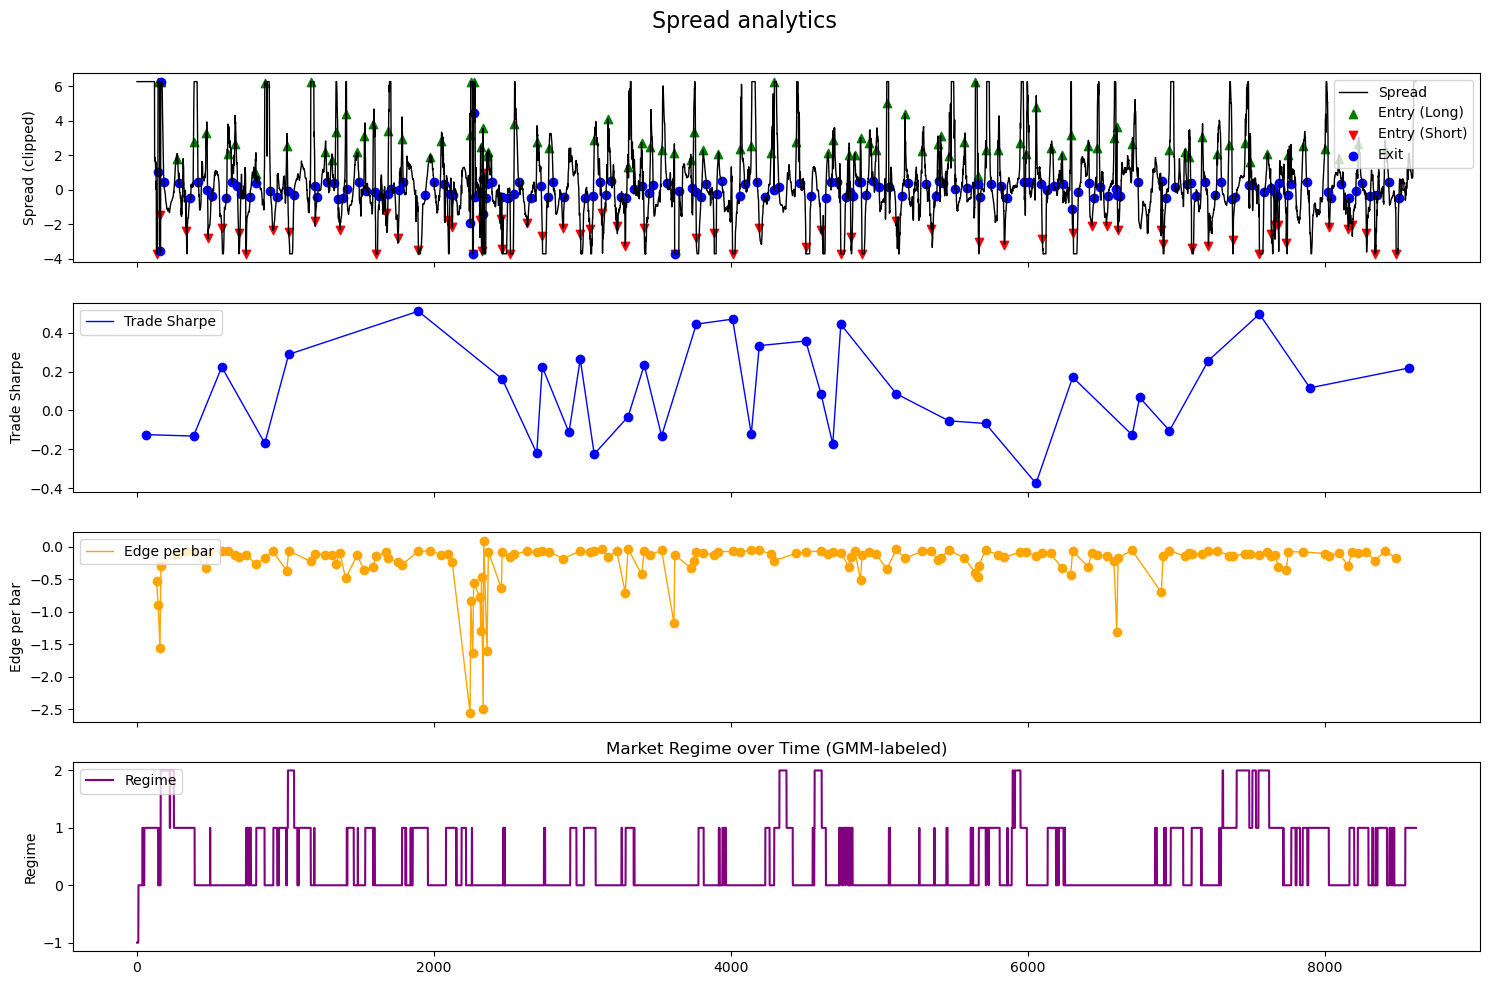

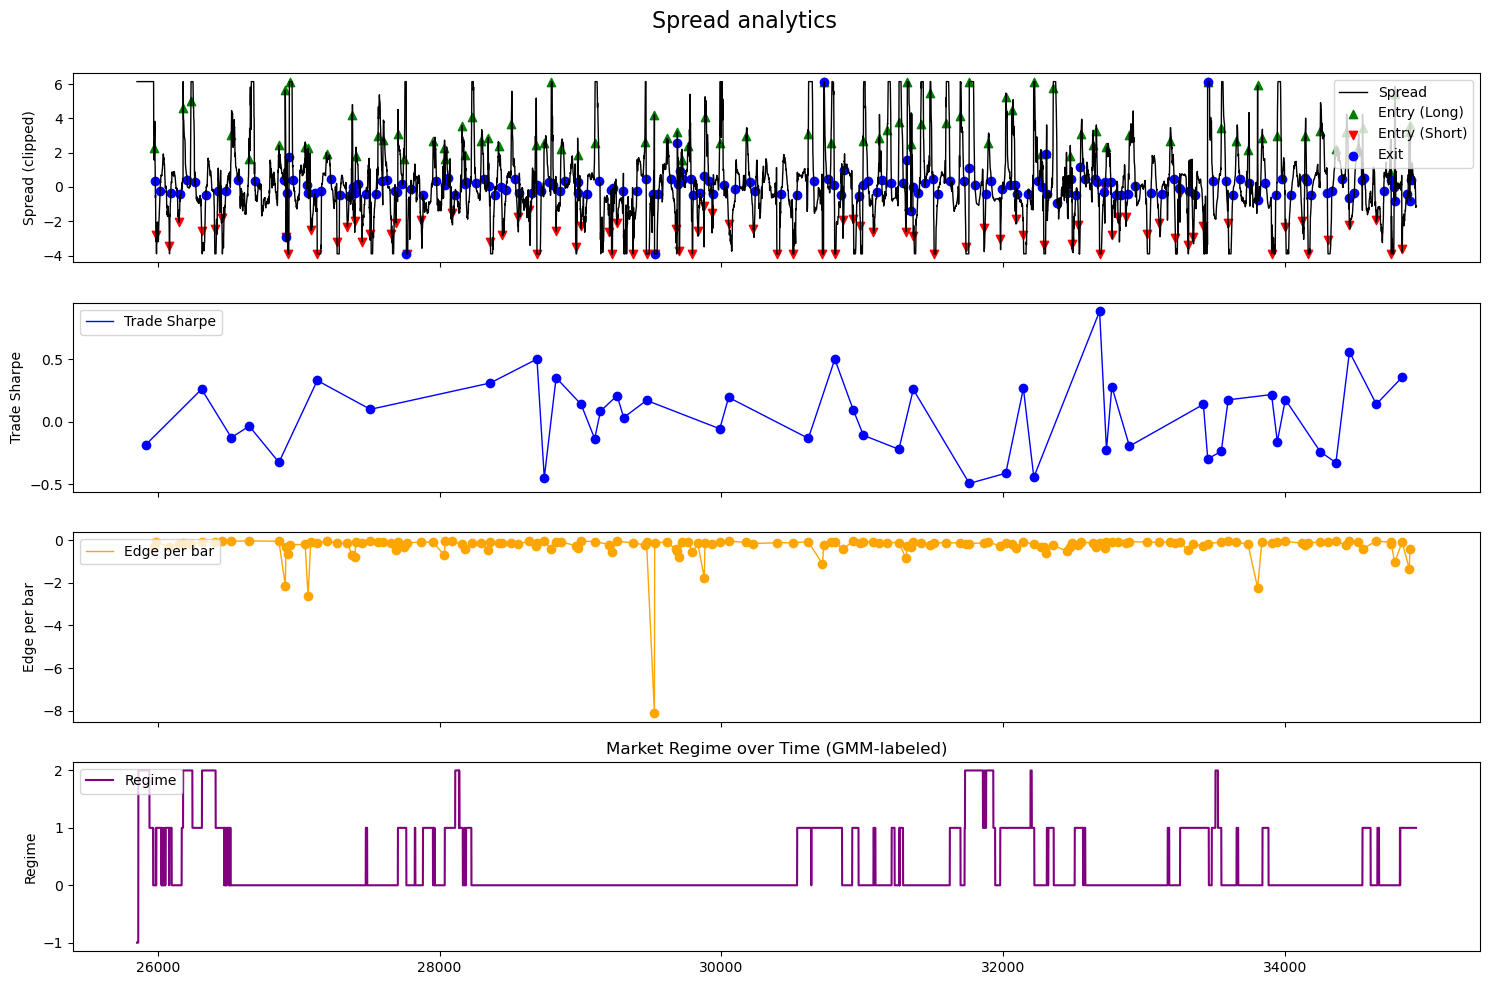

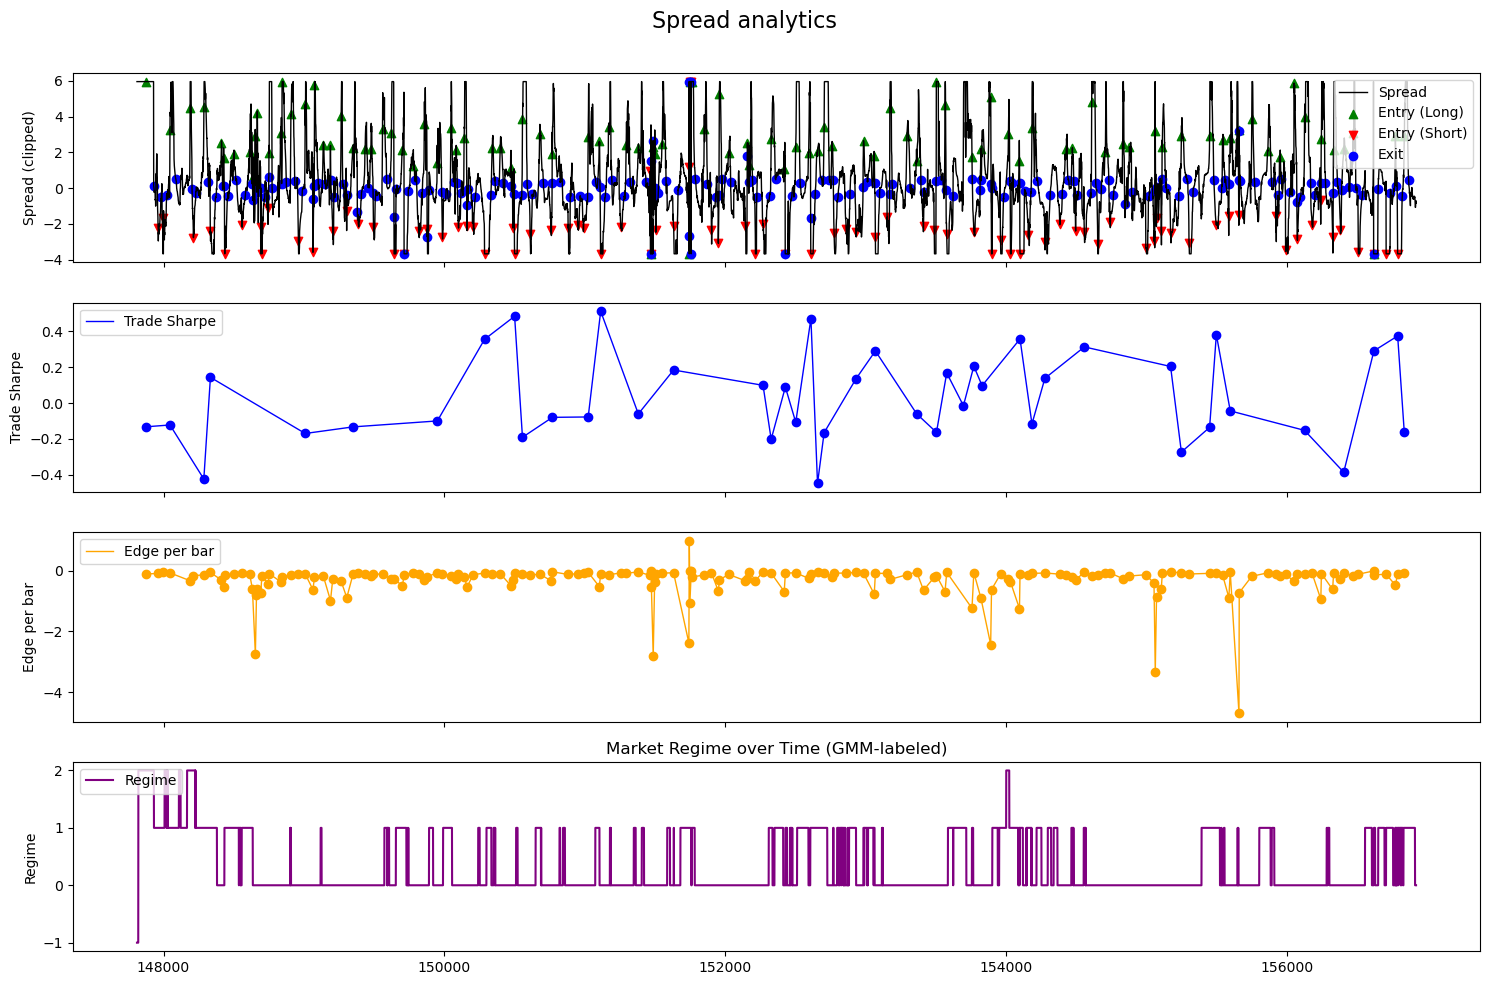

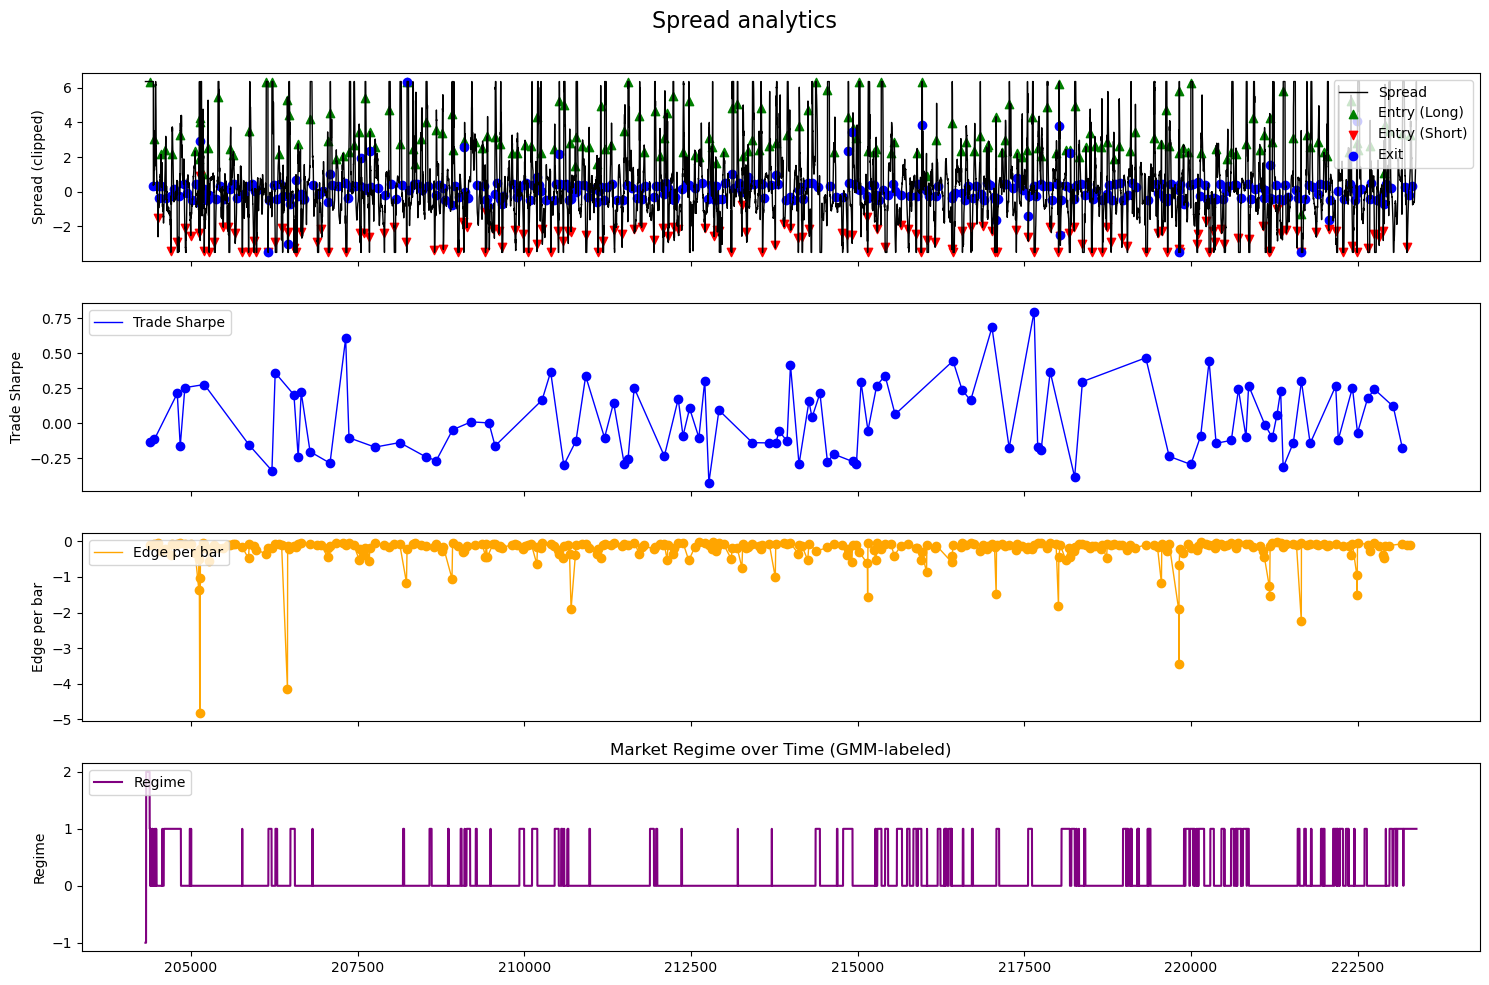

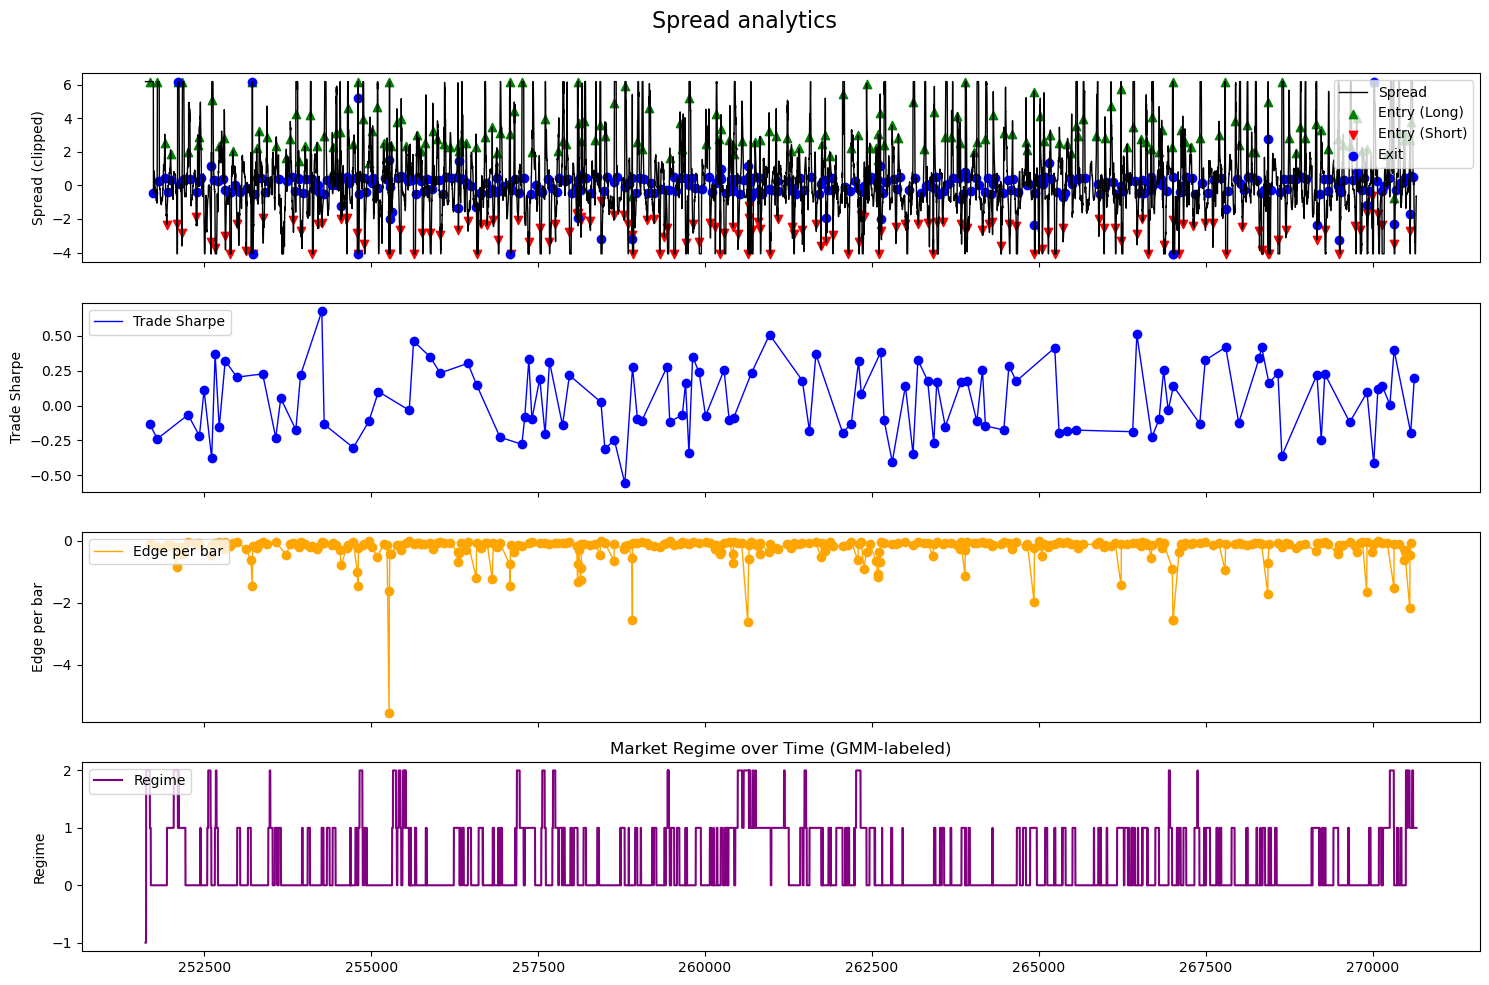

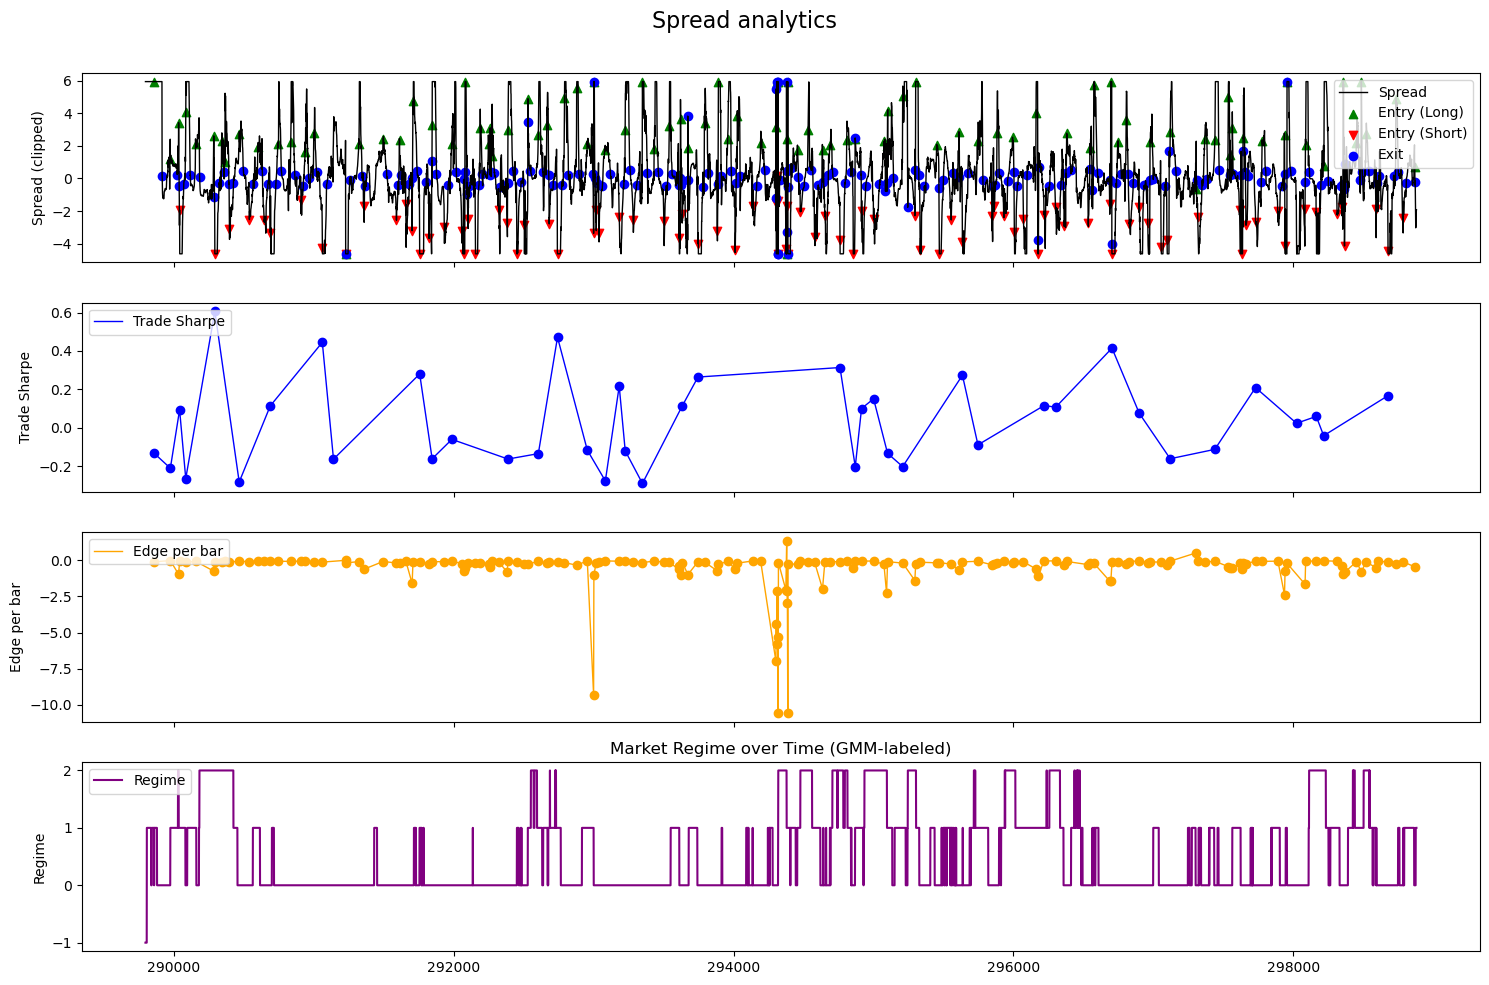

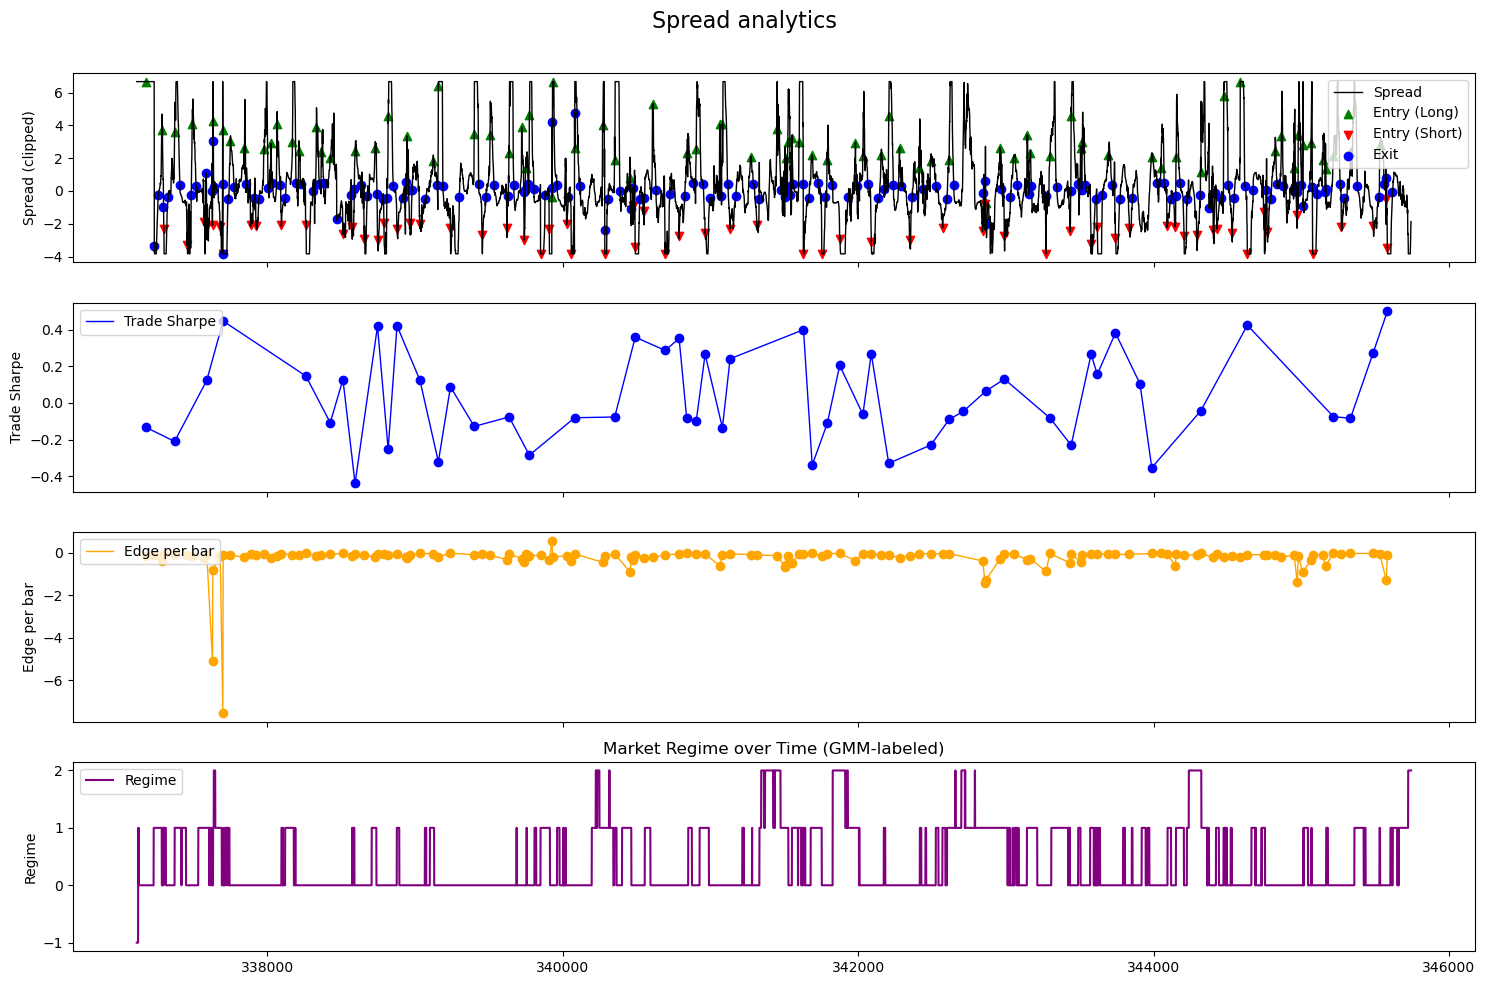

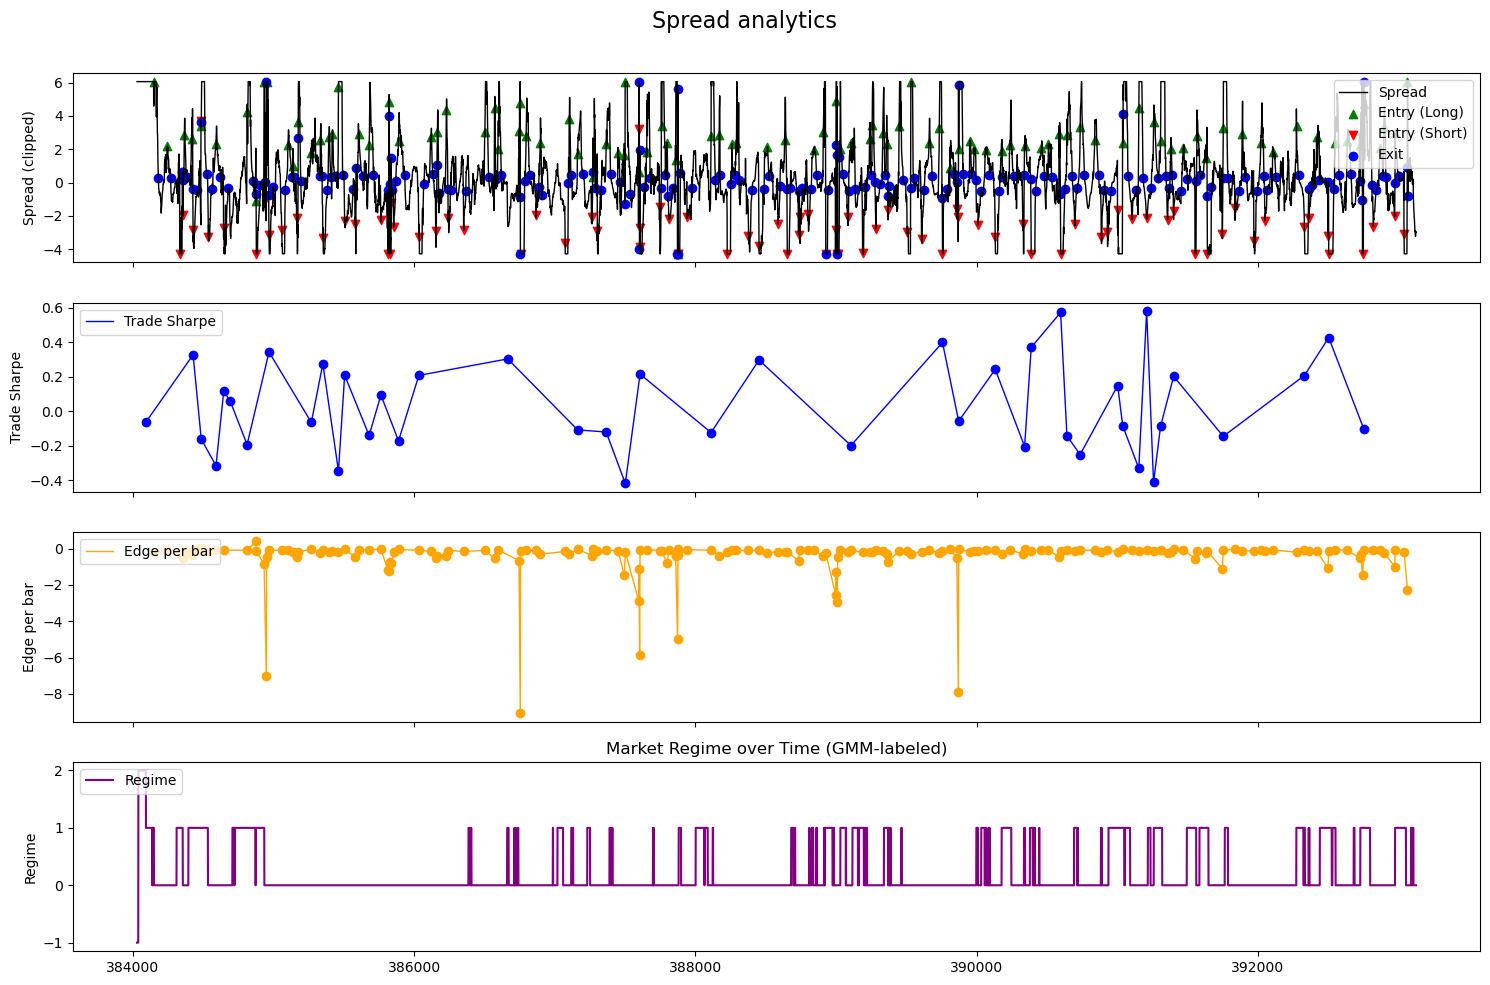

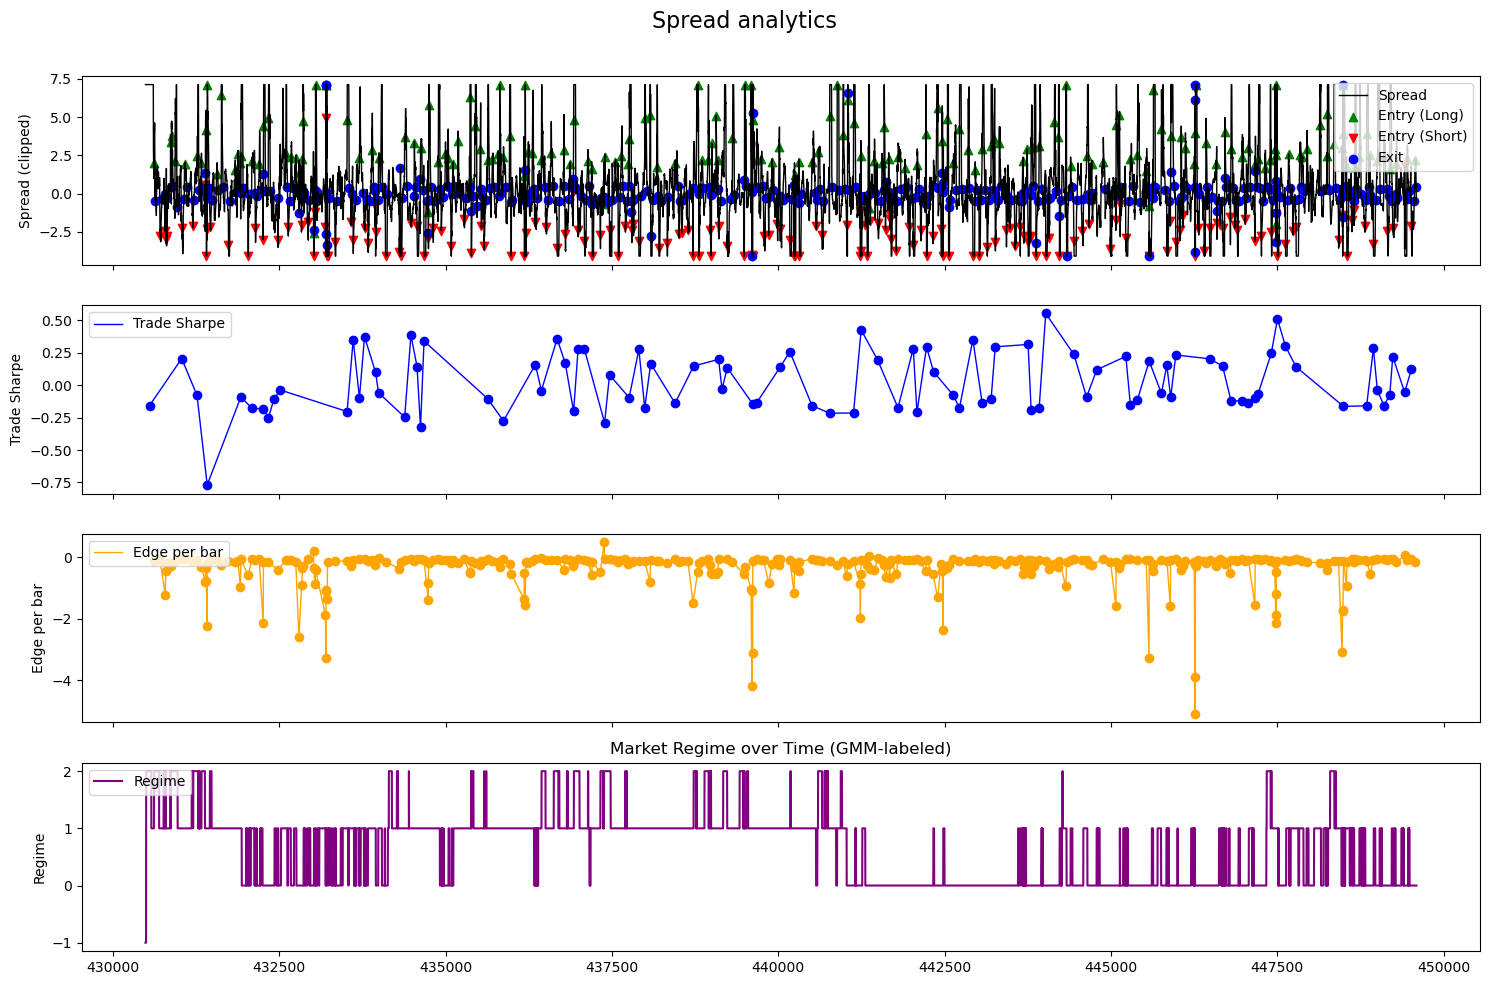

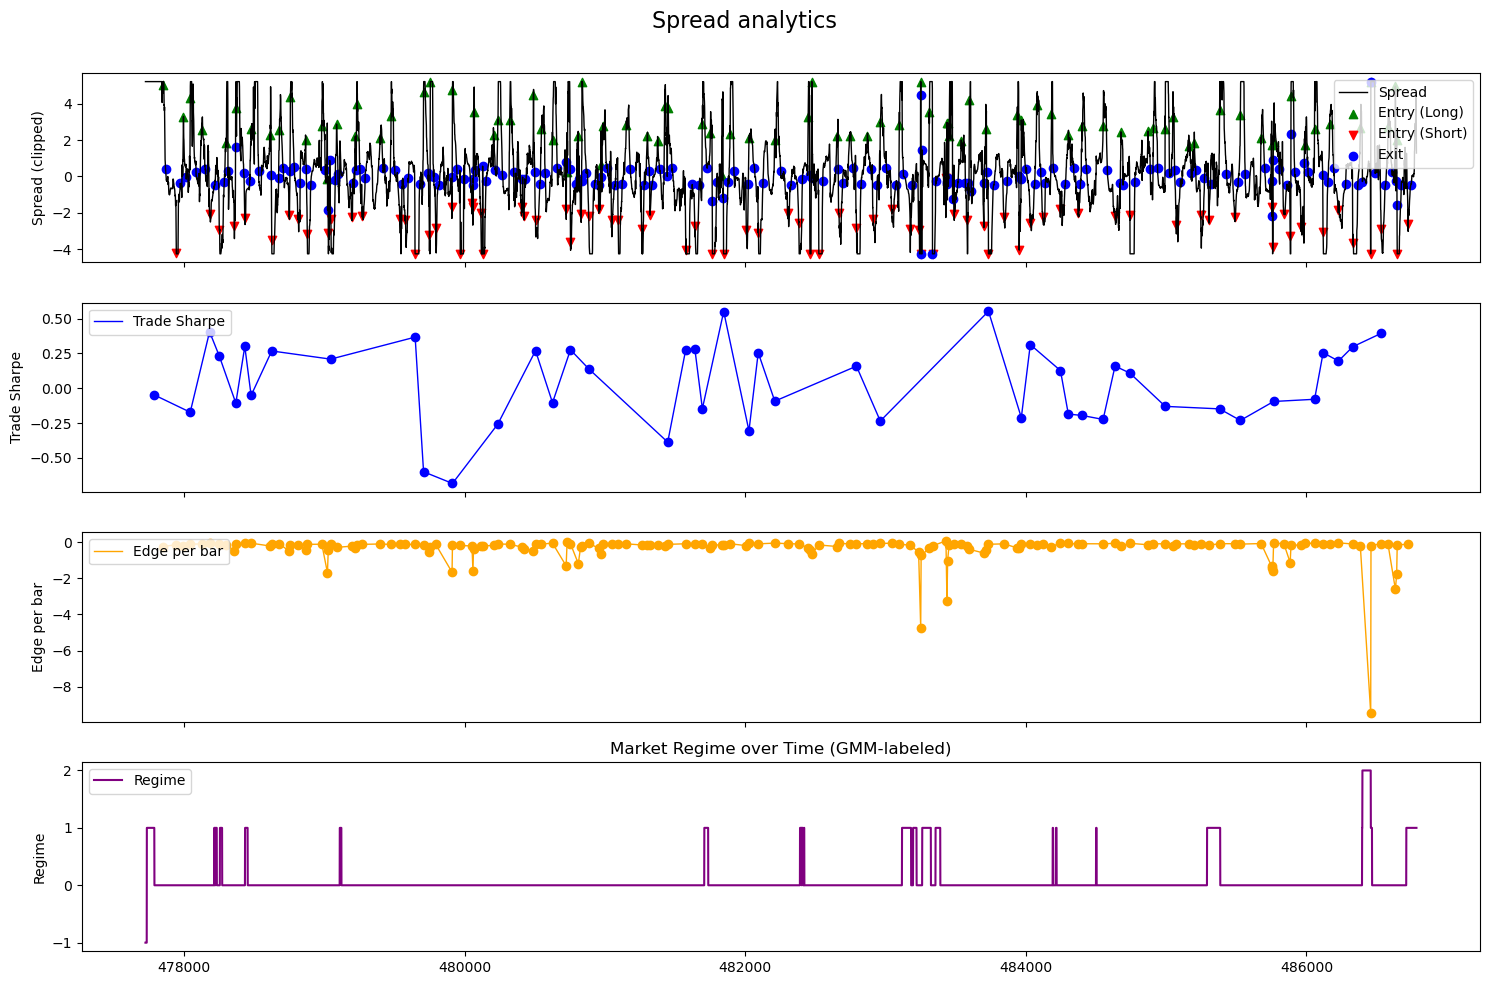

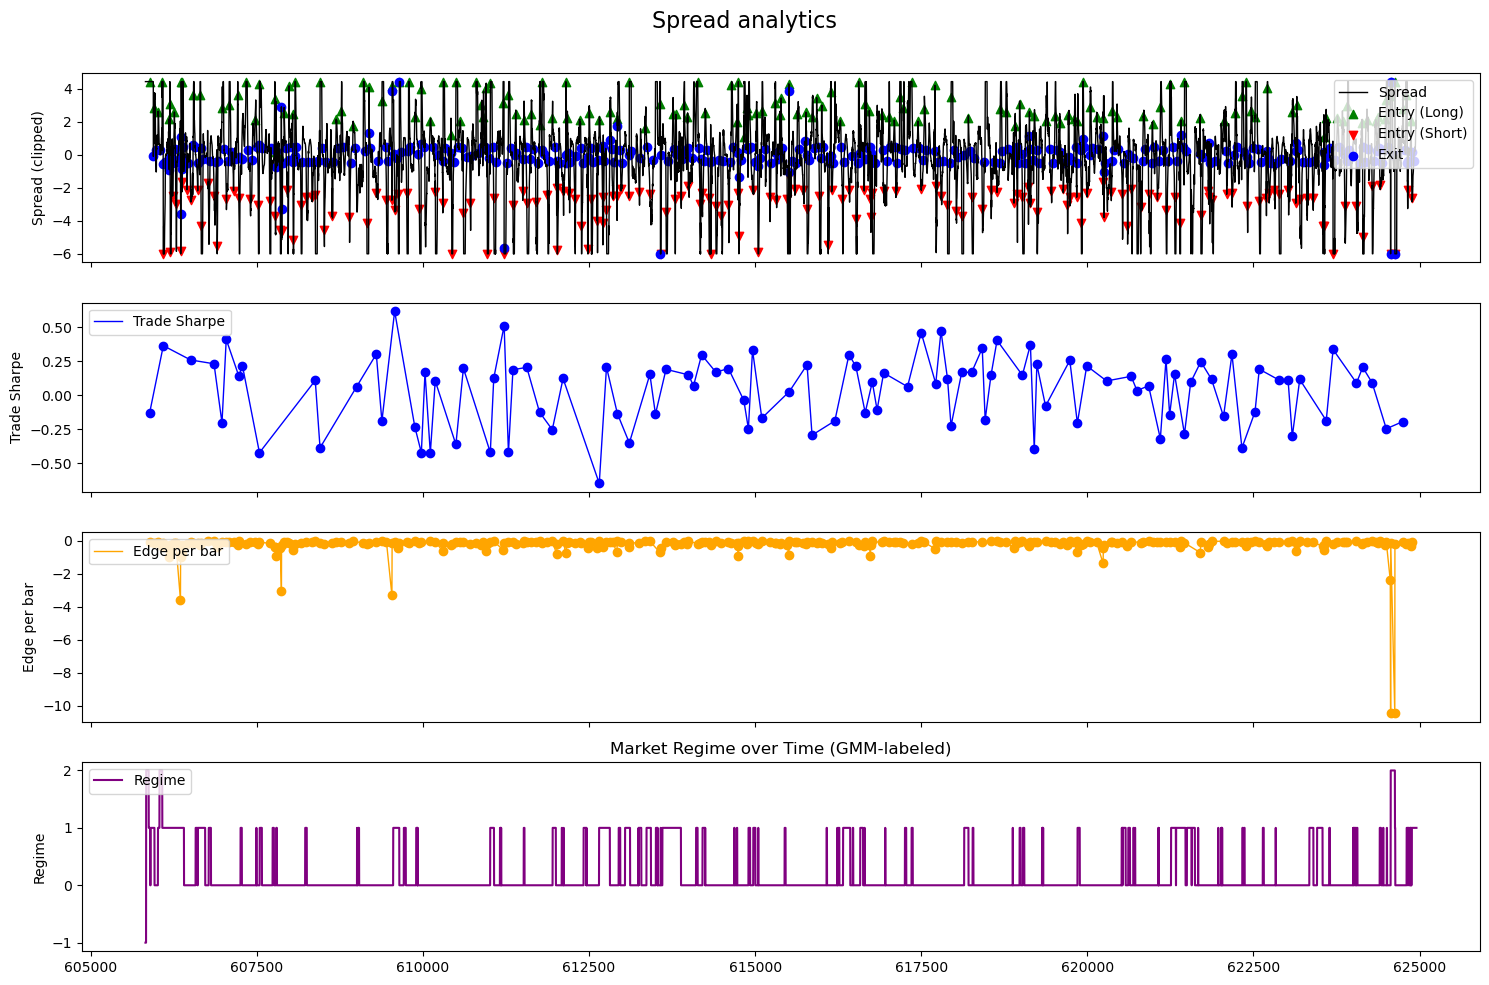

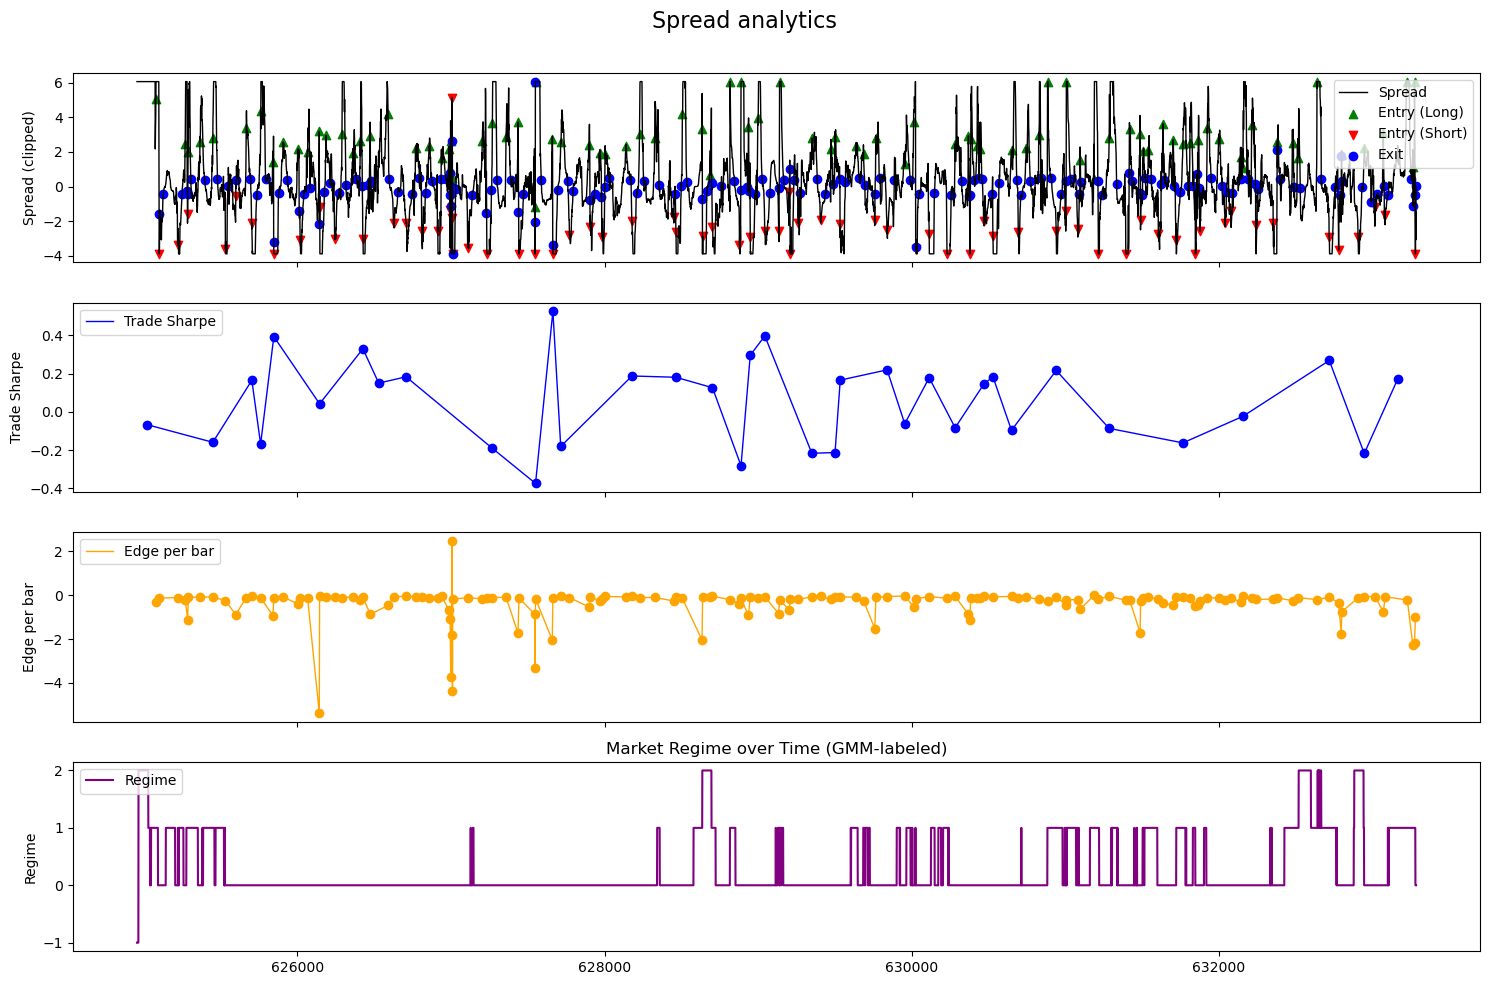

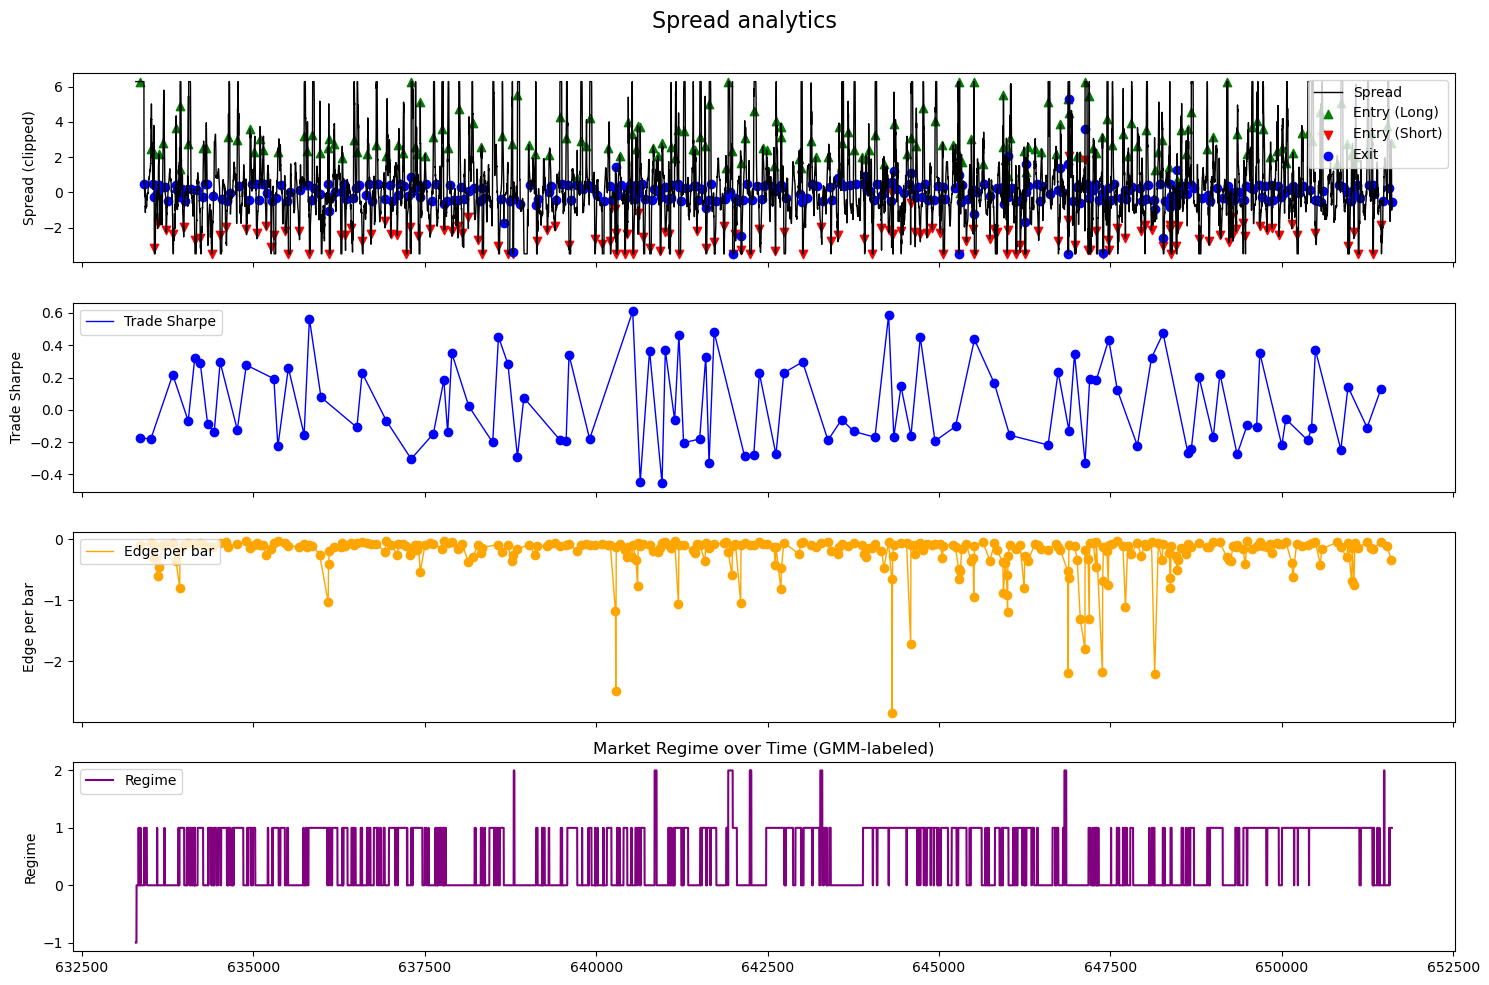

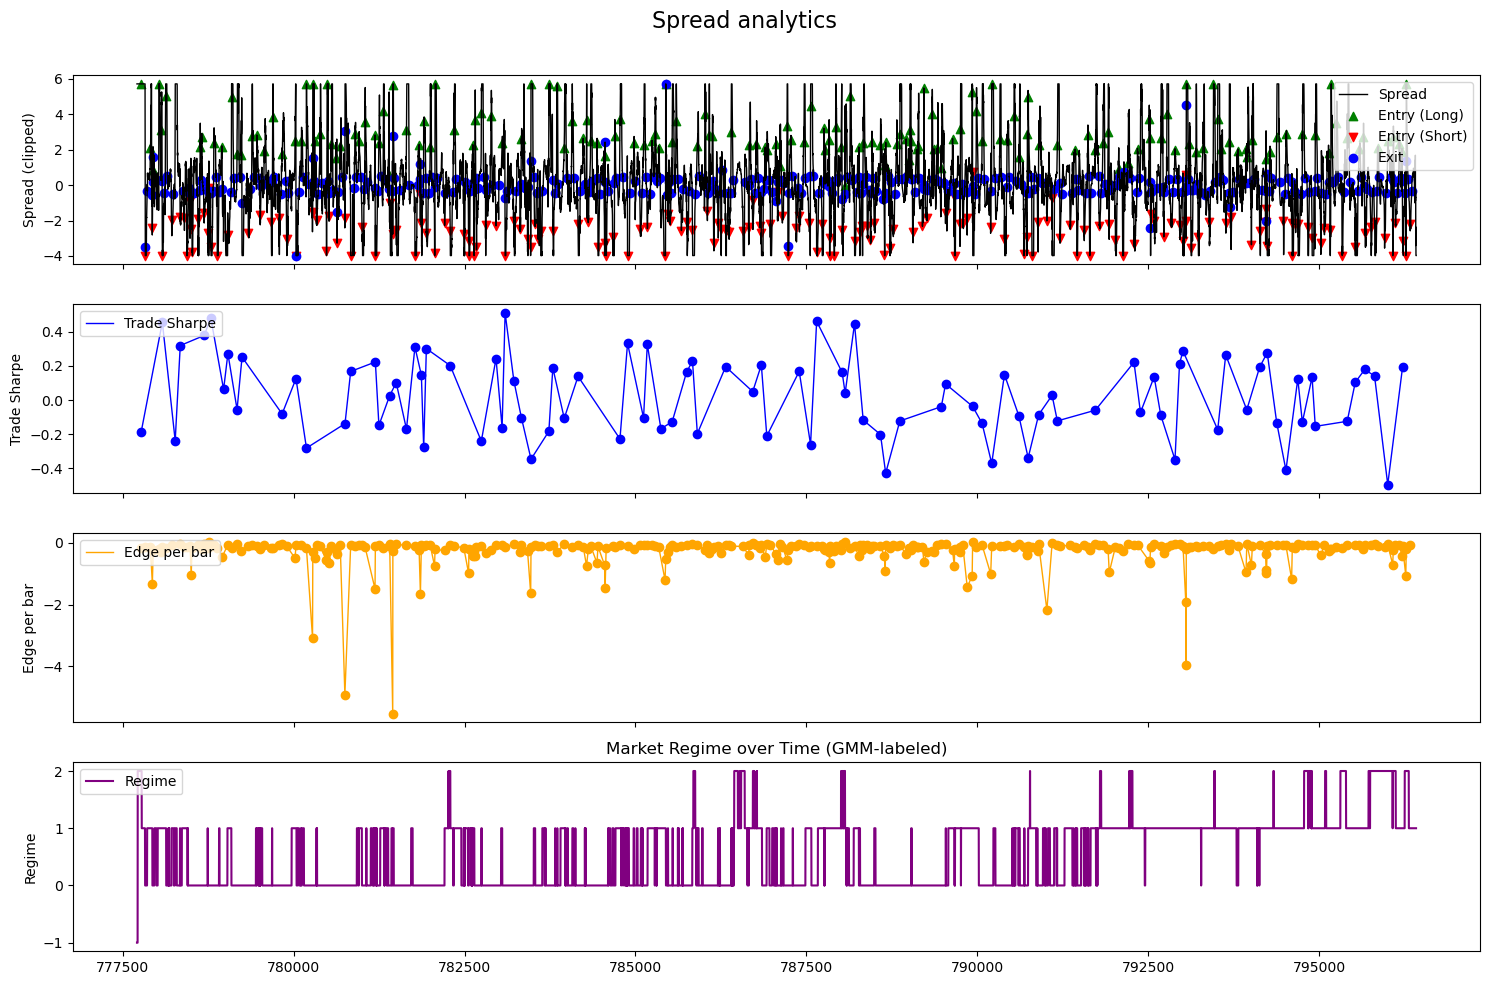

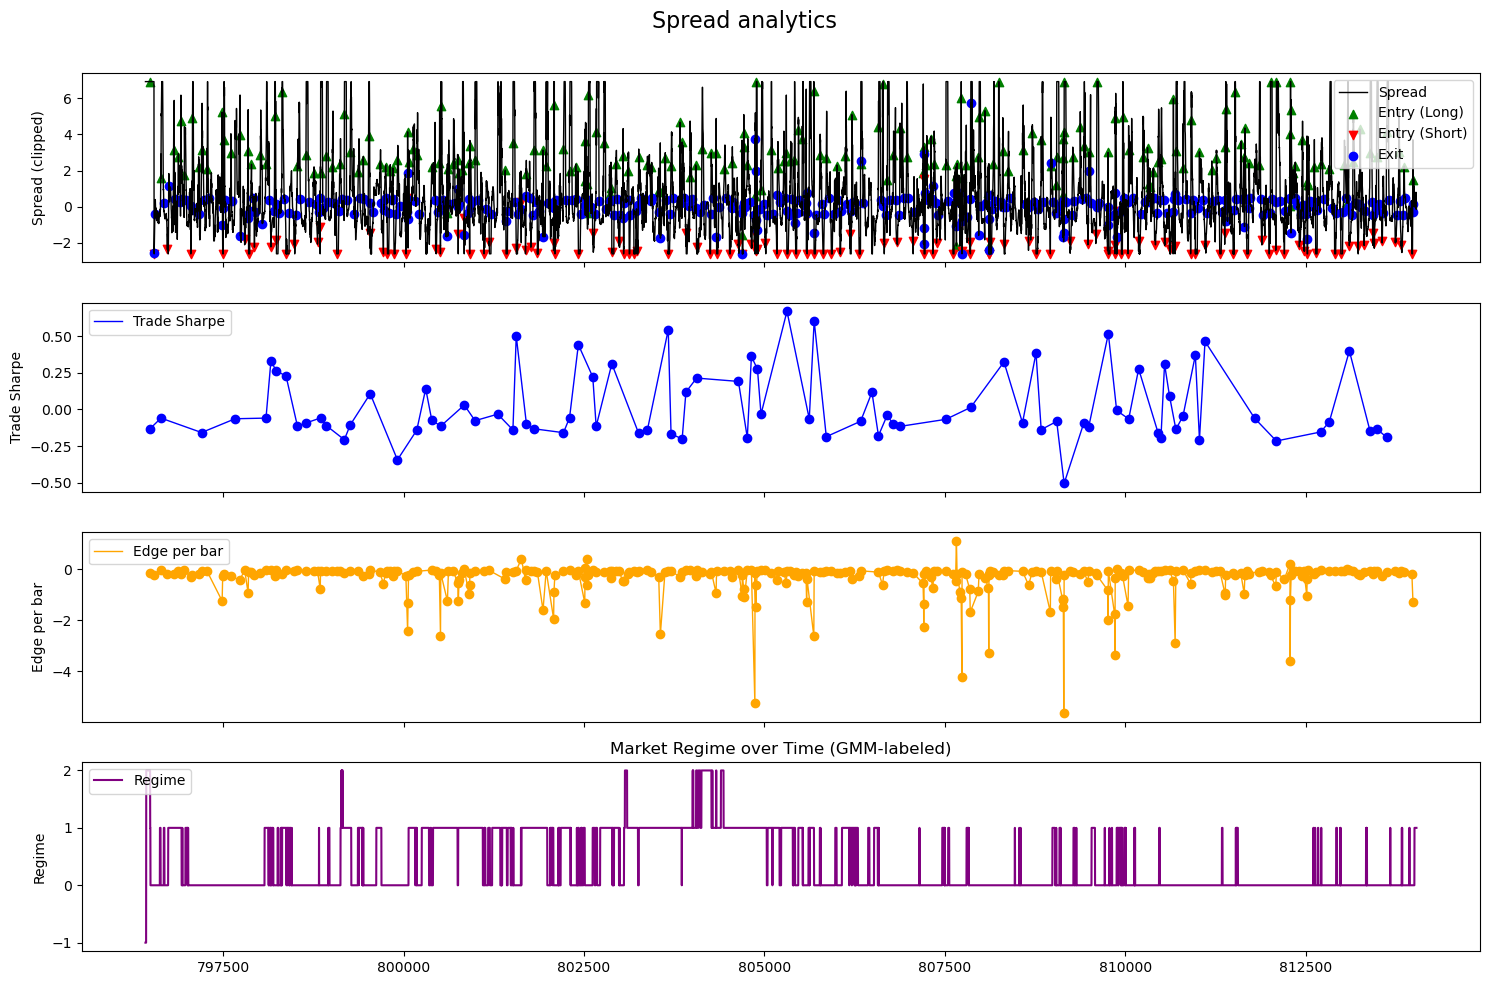

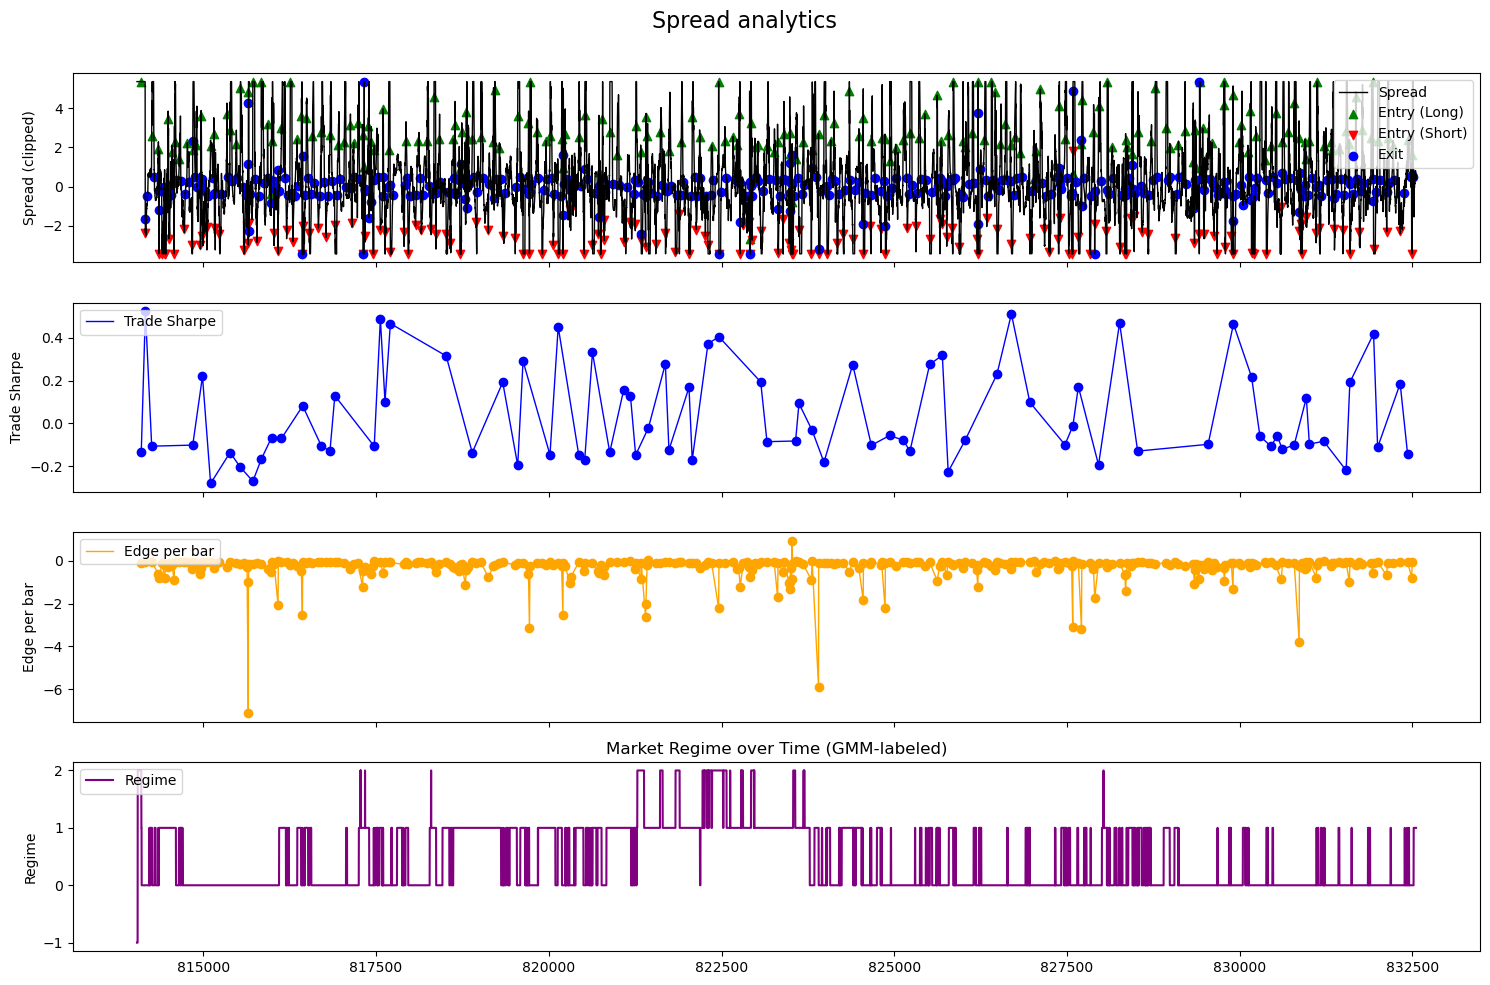


=== Summary statistics for all spreads (sorted by annualized Sharpe) ===


spread  ann_trade_sharpe  mean_reversion_time  \
0   (BTC-USDT-220107, BTC-USDT-220114)         12.459896            20.237500   
1   (BTC-USDT-220107, BTC-USDT-220325)         -5.496823            21.921569   
2   (BTC-USDT-220107, BTC-USDT-220624)         -2.493371            24.141892   
3   (BTC-USDT-220114, BTC-USDT-220121)          5.705469            21.286550   
4   (BTC-USDT-220114, BTC-USDT-220325)         -0.777308            22.900000   
5   (BTC-USDT-220114, BTC-USDT-220624)         -3.723410            25.141066   
6   (BTC-USDT-220121, BTC-USDT-220128)         -2.660498            22.549669   
7   (BTC-USDT-220121, BTC-USDT-220325)         -4.161540            22.005917   
8   (BTC-USDT-220128, BTC-USDT-220204)         -0.982705            18.398058   
9   (BTC-USDT-220128, BTC-USDT-220325)         -2.781900            23.283951   
10  (BTC-USDT-220128, BTC-USDT-220624)         -1.020697            23.722930   
11  (BTC-USDT-220204, BTC-USDT-220211)          4.104743            19.962766   
12  (BTC-USDT-220204, BTC-USDT-220325)          0.263567            22.385507   
13  (BTC-USDT-220204, BTC-USDT-220624)         -0.929615            22.065527   
14  (BTC-USDT-220211, BTC-USDT-220218)         -0.713749            19.715847   
15  (BTC-USDT-220211, BTC-USDT-220325)          2.932616            22.186944   
16  (BTC-USDT-220211, BTC-USDT-220624)         -7.531521            21.513736   
17  (BTC-USDT-220218, BTC-USDT-220225)         -3.364877            22.305389   
18  (BTC-USDT-220218, BTC-USDT-220325)          5.587849            22.879765   
19  (BTC-USDT-220218, BTC-USDT-220624)         -1.597707            21.187845   
20  (BTC-USDT-220225, BTC-USDT-220304)          4.215143            19.413978   
21  (BTC-USDT-220225, BTC-USDT-220325)         -3.344959            20.819209   
22  (BTC-USDT-220225, BTC-USDT-220624)         -0.460548            21.184211   
23  (BTC-USDT-220304, BTC-USDT-220311)          5.293686            22.980392   
24  (BTC-USDT-220304, BTC-USDT-220325)          1.066249            21.141243   
25  (BTC-USDT-220304, BTC-USDT-220624)         -2.262400            22.333333   
26  (BTC-USDT-220311, BTC-USDT-220318)          4.190216            19.805405   
27  (BTC-USDT-220311, BTC-USDT-220325)          0.102393            21.958209   
28  (BTC-USDT-220311, BTC-USDT-220624)         -2.379364            21.837607   
29  (BTC-USDT-220318, BTC-USDT-220325)          3.830987            21.022727   
30  (BTC-USDT-220318, BTC-USDT-220624)         -2.609148            21.269122   
31  (BTC-USDT-220318, BTC-USDT-220930)          1.873179            22.204819   
32  (BTC-USDT-220325, BTC-USDT-220401)          4.954761            21.711765   
33  (BTC-USDT-220325, BTC-USDT-220624)         -2.383450            22.614102   
34  (BTC-USDT-220325, BTC-USDT-220930)          4.622891            23.768519   
35  (BTC-USDT-220401, BTC-USDT-220408)          7.148552            19.623457   
36  (BTC-USDT-220401, BTC-USDT-220624)          4.739100            21.686747   
37  (BTC-USDT-220401, BTC-USDT-220930)         -1.468194            22.342424   
38  (BTC-USDT-220408, BTC-USDT-220415)         -2.532817            19.371134   
39  (BTC-USDT-220408, BTC-USDT-220624)         -0.882420            20.217765   
40  (BTC-USDT-220408, BTC-USDT-220930)         -3.499442            20.151261   
41  (BTC-USDT-220415, BTC-USDT-220624)         -2.695642            20.000000   
42  (BTC-USDT-220415, BTC-USDT-220930)         -1.224904            19.986737   
43  (BTC-USDT-220513, BTC-USDT-220520)          0.828759            18.410526   
44  (BTC-USDT-220513, BTC-USDT-220624)         -3.544378            19.803030   
45  (BTC-USDT-220513, BTC-USDT-220930)          3.050147            21.935103   
46  (BTC-USDT-220520, BTC-USDT-220624)          2.537555            19.731343   
47  (BTC-USDT-220520, BTC-USDT-220930)          5.458224            19.806630   
48  (BTC-USDT-220624, BTC-USDT-220930)         -0.079634       

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

all_stats = []

bars_per_day = 48  
days_per_year = 365  
bars_per_year = bars_per_day * days_per_year

for key, spread in spreads.items():
    spread = spread.copy()
    
    stats_df, spread = mean_reversion_stats(
        spread,
        entry_threshold=2,
        exit_threshold=0.5,
        max_horizon=60,
        min_periods=30  
    )

    mean_trade_sharpe = stats_df['trade_sharpe'].mean()
    ann_trade_sharpe = mean_trade_sharpe * np.sqrt(bars_per_year) if not np.isnan(mean_trade_sharpe) else np.nan

    summary = {
        'spread': key,
        'ann_trade_sharpe': ann_trade_sharpe,
        'mean_reversion_time': stats_df['reversion_time'].dropna().mean(),
        'median_reversion_time': stats_df['reversion_time'].dropna().median(),
        'failure_rate': stats_df['reversion_time'].isna().mean(),
        'avg_move': stats_df['spread_move'].mean(),
        'avg_mae': stats_df['max_adverse'].mean(),
        'avg_mfe': stats_df['max_favorable'].mean(),
        'avg_edge_per_bar': stats_df['edge_per_bar'].mean(),
        'avg_rolling_sharpe': stats_df['trade_sharpe'].mean()    
    }
    all_stats.append(summary)
    
    spread_clip = spread.copy()
    p01 = spread_clip['vol_adj_spread_wins'].quantile(0.01)
    p99 = spread_clip['vol_adj_spread_wins'].quantile(0.99)
    spread_clip['vol_adj_spread_wins'] = spread_clip['vol_adj_spread_wins'].clip(p01, p99)
    
    if ann_trade_sharpe > 2:
        plot_spread_analytics(spread, stats_df)



In [13]:
display(summary_df.sort_values(by='ann_trade_sharpe', ascending=False))

spread  ann_trade_sharpe  mean_reversion_time  \
0   (BTC-USDT-220107, BTC-USDT-220114)         12.459896            20.237500   
35  (BTC-USDT-220401, BTC-USDT-220408)          7.148552            19.623457   
3   (BTC-USDT-220114, BTC-USDT-220121)          5.705469            21.286550   
18  (BTC-USDT-220218, BTC-USDT-220325)          5.587849            22.879765   
47  (BTC-USDT-220520, BTC-USDT-220930)          5.458224            19.806630   
23  (BTC-USDT-220304, BTC-USDT-220311)          5.293686            22.980392   
32  (BTC-USDT-220325, BTC-USDT-220401)          4.954761            21.711765   
36  (BTC-USDT-220401, BTC-USDT-220624)          4.739100            21.686747   
34  (BTC-USDT-220325, BTC-USDT-220930)          4.622891            23.768519   
20  (BTC-USDT-220225, BTC-USDT-220304)          4.215143            19.413978   
26  (BTC-USDT-220311, BTC-USDT-220318)          4.190216            19.805405   
11  (BTC-USDT-220204, BTC-USDT-220211)          4.104743            19.962766   
29  (BTC-USDT-220318, BTC-USDT-220325)          3.830987            21.022727   
45  (BTC-USDT-220513, BTC-USDT-220930)          3.050147            21.935103   
15  (BTC-USDT-220211, BTC-USDT-220325)          2.932616            22.186944   
46  (BTC-USDT-220520, BTC-USDT-220624)          2.537555            19.731343   
31  (BTC-USDT-220318, BTC-USDT-220930)          1.873179            22.204819   
24  (BTC-USDT-220304, BTC-USDT-220325)          1.066249            21.141243   
43  (BTC-USDT-220513, BTC-USDT-220520)          0.828759            18.410526   
12  (BTC-USDT-220204, BTC-USDT-220325)          0.263567            22.385507   
27  (BTC-USDT-220311, BTC-USDT-220325)          0.102393            21.958209   
48  (BTC-USDT-220624, BTC-USDT-220930)         -0.079634            19.710039   
22  (BTC-USDT-220225, BTC-USDT-220624)         -0.460548            21.184211   
14  (BTC-USDT-220211, BTC-USDT-220218)         -0.713749            19.715847   
4   (BTC-USDT-220114, BTC-USDT-220325)         -0.777308            22.900000   
39  (BTC-USDT-220408, BTC-USDT-220624)         -0.882420            20.217765   
13  (BTC-USDT-220204, BTC-USDT-220624)         -0.929615            22.065527   
8   (BTC-USDT-220128, BTC-USDT-220204)         -0.982705            18.398058   
10  (BTC-USDT-220128, BTC-USDT-220624)         -1.020697            23.722930   
42  (BTC-USDT-220415, BTC-USDT-220930)         -1.224904            19.986737   
37  (BTC-USDT-220401, BTC-USDT-220930)         -1.468194            22.342424   
19  (BTC-USDT-220218, BTC-USDT-220624)         -1.597707            21.187845   
25  (BTC-USDT-220304, BTC-USDT-220624)         -2.262400            22.333333   
28  (BTC-USDT-220311, BTC-USDT-220624)         -2.379364            21.837607   
33  (BTC-USDT-220325, BTC-USDT-220624)         -2.383450            22.614102   
2   (BTC-USDT-220107, BTC-USDT-220624)         -2.493371            24.141892   
38  (BTC-USDT-220408, BTC-USDT-220415)         -2.532817            19.371134   
30  (BTC-USDT-220318, BTC-USDT-220624)         -2.609148            21.269122   
6   (BTC-USDT-220121, BTC-USDT-220128)         -2.660498            22.549669   
41  (BTC-USDT-220415, BTC-USDT-220624)         -2.695642            20.000000   
9   (BTC-USDT-220128, BTC-USDT-220325)         -2.781900            23.283951   
21  (BTC-USDT-220225, BTC-USDT-220325)         -3.344959            20.819209   
17  (BTC-USDT-220218, BTC-USDT-220225)         -3.364877            22.305389   
40  (BTC-USDT-220408, BTC-USDT-220930)         -3.499442            20.151261   
44  (BTC-USDT-220513, BTC-USDT-220624)         -3.544378            19.803030   
5   (BTC-USDT-220114, BTC-USDT-220624)         -3.723410            25.141066   
7   (BTC-USDT-220121, BTC-USDT-220325)         -4.161540            22.005917   
1   (BTC-USDT-220107, BTC-USDT-220325)         -5.496823            21.921569   
16  (BTC-USDT-220211, BTC-USDT-220624)         -7.531521       

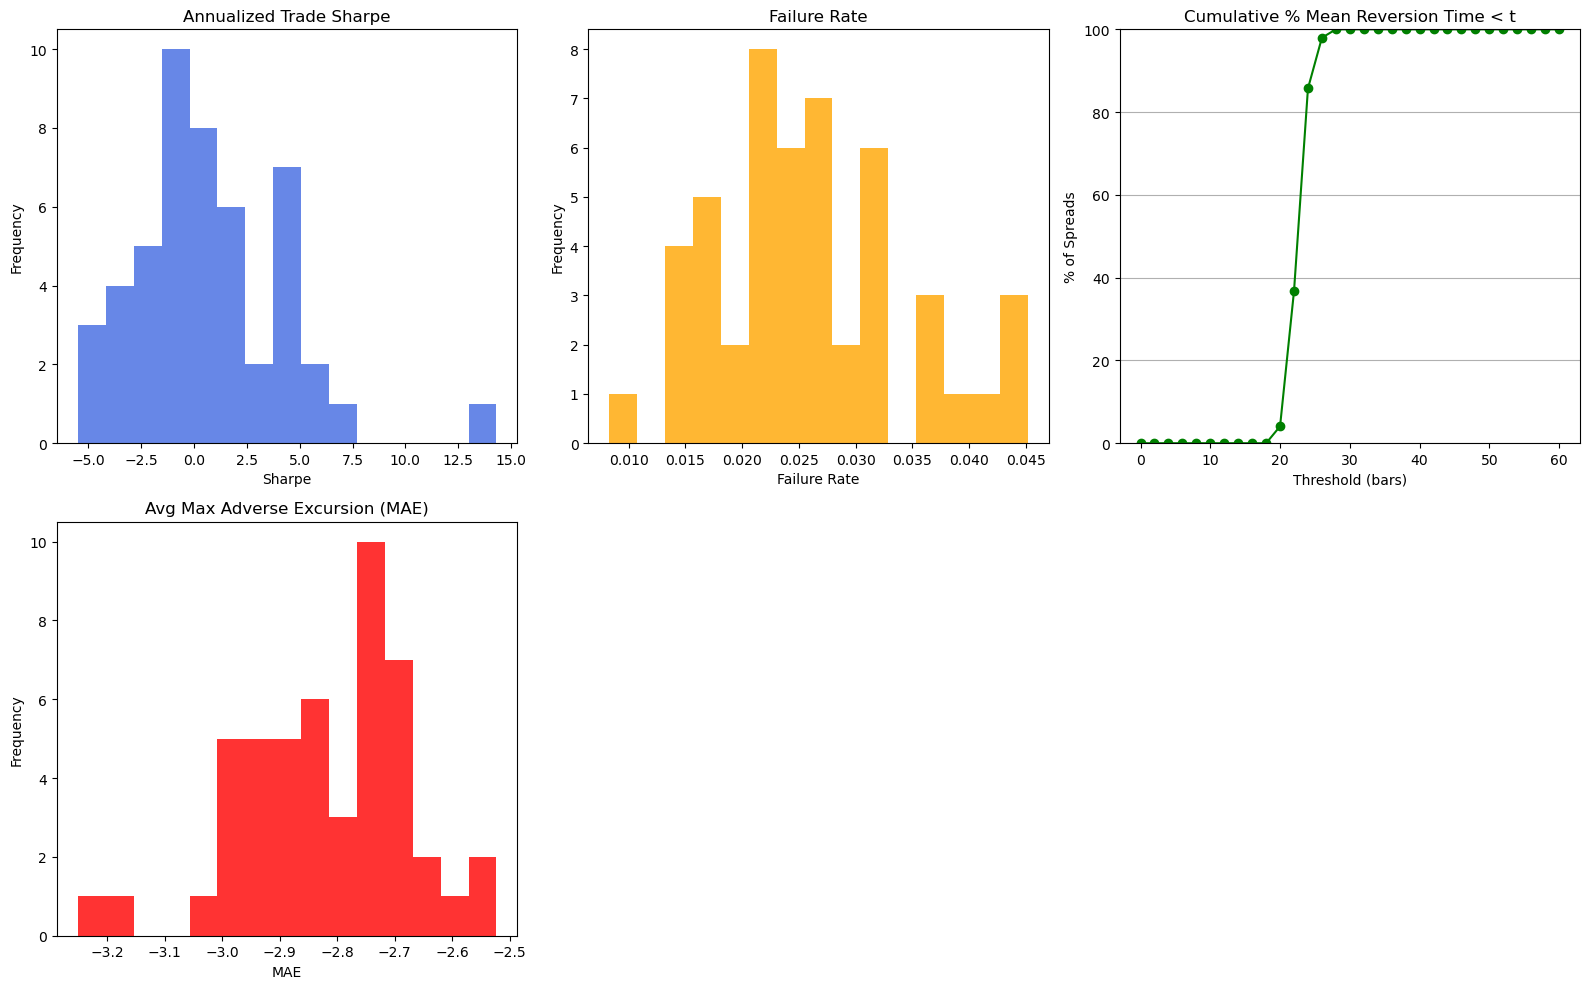

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.hist(summary_df['ann_trade_sharpe'].dropna(), bins=15, color='royalblue', alpha=0.8)
plt.title('Annualized Trade Sharpe')
plt.xlabel('Sharpe')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(summary_df['fialure_rate'].dropna(), bins=15, color='orange', alpha=0.8)
plt.title('Failure Rate')
plt.xlabel('Failure Rate')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
thresholds = np.arange(0, 61, 2)  
percentages = []
for t in thresholds:
    pct = (summary_df['mean_reversion_time'] < t).mean() * 100
    percentages.append(pct)
plt.plot(thresholds, percentages, marker='o', color='green')
plt.title('Cumulative % Mean Reversion Time < t')
plt.xlabel('Threshold (bars)')
plt.ylabel('% of Spreads')
plt.ylim(0, 100)
plt.grid(True, axis='y')

plt.subplot(2, 3, 4)
plt.hist(summary_df['avg_mae'].dropna(), bins=15, color='red', alpha=0.8)
plt.title('Avg Max Adverse Excursion (MAE)')
plt.xlabel('MAE')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
